# Euclidean space

* Load original embeddings
* Euclidean MDS

In [17]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [3]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [31]:
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.533656144278276, pvalue=7.551922897105732e-177)

In [32]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [33]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [34]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [42]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
#     concept_in_feat_coord.append(mobius_addition(normalized_embeddings, feature_embeddings[:,:,layer], 48))
np.array(concept_in_feat_coord).shape

(1854, 16)

In [47]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,0.257196,-0.149601,0.097700,0.486571,-0.233932,-0.245791,-0.208891,-0.125042,0.207229,-0.327346,-0.429370,-0.037573,0.198956,-0.364910,0.262268,0.042607,0.779739,1,animal
1,1,0.096372,-0.318087,0.098610,0.157793,-0.483288,0.096272,-0.014961,0.145142,0.152316,-0.133918,-0.322260,-0.518186,-0.236083,-0.494755,-0.079463,-0.186821,0.798485,13,home decor
2,2,0.251363,-0.428372,-0.159658,0.183401,-0.629407,-0.192000,-0.175446,-0.112185,0.342690,-0.180025,-0.097542,-0.423873,-0.371135,-0.102663,-0.117751,0.017678,0.752845,18,musical instrument
4,4,0.087201,0.012009,-0.120919,0.175571,-0.309702,0.164404,-0.634352,0.060360,0.019642,-0.253163,-0.054509,-0.350359,-0.142951,0.081127,0.455223,0.343431,0.794466,9,electronic device
5,5,-0.069450,-0.003989,-0.214316,0.218524,-0.069509,0.065671,-0.320716,-0.083294,-0.057517,-0.262883,-0.080062,-0.174070,-0.007727,0.220850,-0.004462,0.462100,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.089642,-0.243565,-0.091813,-0.098626,0.321606,-0.589159,0.543529,-0.012458,-0.332253,0.037118,-0.358885,-0.100520,-0.163182,-0.109911,-0.185898,0.061870,0.803129,24,toy
1848,1848,-0.260872,0.188415,-0.087191,-0.014198,0.033958,-0.101392,-0.234838,-0.182751,0.306640,0.000255,-0.644833,-0.185797,-0.121185,-0.335999,-0.227808,0.185564,0.765881,10,food
1850,1850,-0.318909,0.095347,-0.165039,0.002044,0.041825,-0.126988,-0.141498,-0.154243,0.257153,-0.291410,-0.586038,-0.259464,-0.091292,-0.388438,-0.104259,0.016681,0.843158,10,food
1851,1851,0.306011,-0.125838,0.272022,0.457860,-0.221812,-0.235201,-0.226816,-0.101833,0.188664,-0.319993,-0.233460,-0.081794,0.178557,-0.230379,0.373962,-0.074590,0.800163,1,animal


### Cartesian

In [49]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.257196,-0.149601,0.097700,0.486571,-0.233932,-0.245791,-0.208891,-0.125042,0.207229,-0.327346,-0.429370,-0.037573,0.198956,-0.364910,0.262268,0.042607
1,0.096372,-0.318087,0.098610,0.157793,-0.483288,0.096272,-0.014961,0.145142,0.152316,-0.133918,-0.322260,-0.518186,-0.236083,-0.494755,-0.079463,-0.186821
2,0.251363,-0.428372,-0.159658,0.183401,-0.629407,-0.192000,-0.175446,-0.112185,0.342690,-0.180025,-0.097542,-0.423873,-0.371135,-0.102663,-0.117751,0.017678
3,-0.209458,0.096631,-0.053226,0.158000,-0.329125,-0.195598,-0.004283,-0.101134,0.008116,-0.283229,-0.677842,-0.464024,-0.147811,-0.078516,-0.174545,-0.097678
4,0.087201,0.012009,-0.120919,0.175571,-0.309702,0.164404,-0.634352,0.060360,0.019642,-0.253163,-0.054509,-0.350359,-0.142951,0.081127,0.455223,0.343431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,0.175636,0.255003,-0.315909,0.540830,-0.313218,-0.265400,-0.289960,0.159677,0.045721,-0.171844,-0.687148,-0.364709,-0.153321,-0.245648,-0.277209,-0.005902
1850,-0.318909,0.095347,-0.165039,0.002044,0.041825,-0.126988,-0.141498,-0.154243,0.257153,-0.291410,-0.586038,-0.259464,-0.091292,-0.388438,-0.104259,0.016681
1851,0.306011,-0.125838,0.272022,0.457860,-0.221812,-0.235201,-0.226816,-0.101833,0.188664,-0.319993,-0.233460,-0.081794,0.178557,-0.230379,0.373962,-0.074590
1852,-0.101017,0.179974,0.020951,0.270133,-0.157160,-0.273378,-0.250586,-0.177602,0.193230,-0.097730,-0.521441,-0.155626,-0.207604,-0.016020,-0.113886,0.445467


In [50]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     42.69
Date:                Sun, 21 Aug 2022   Prob (F-statistic):          9.84e-114
Time:                        19:03:15   Log-Likelihood:                -2337.7
No. Observations:                1854   AIC:                             4709.
Df Residuals:                    1837   BIC:                             4803.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4592      0.119     -3.858      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Polar coordinates

In [51]:
### Polar coordinates of concepts in hyperbolic feature space
r, theta, rho = cart_to_polar(coordinates.values).T
plt.hist2d(theta, rho,
           bins = 20)

ValueError: too many values to unpack (expected 3)

### Radius

<IPython.core.display.Javascript object>


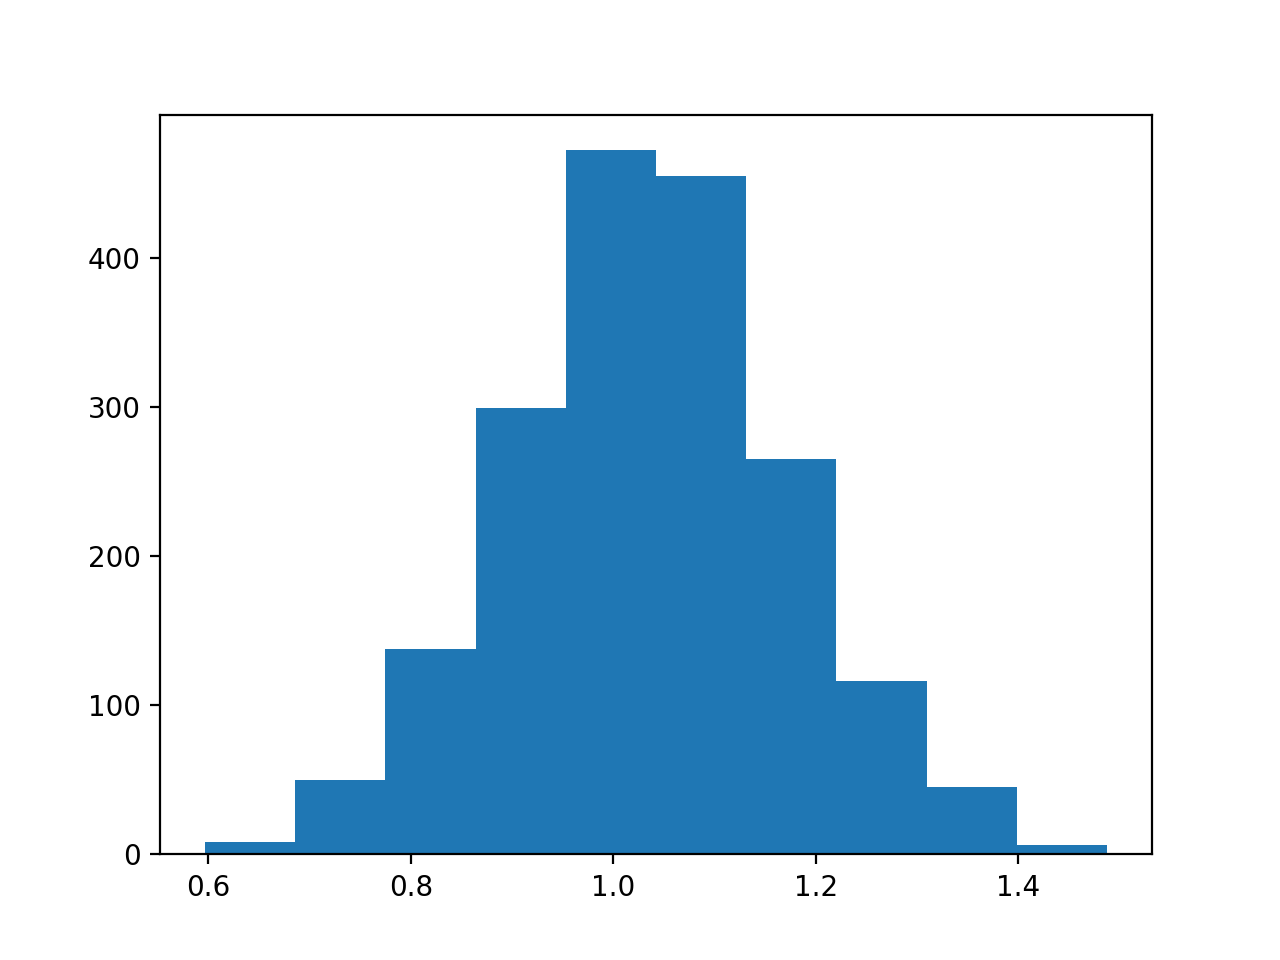

(array([  8.,  50., 138., 299., 472., 455., 265., 116.,  45.,   6.]),
 array([0.59700653, 0.68604189, 0.77507725, 0.86411261, 0.95314797,
        1.04218333, 1.13121869, 1.22025405, 1.30928941, 1.39832477,
        1.48736013]),
 <BarContainer object of 10 artists>)

In [53]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [54]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     11.20
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           0.000832
Time:                        19:09:08   Log-Likelihood:                -2625.1
No. Observations:                1854   AIC:                             5254.
Df Residuals:                    1852   BIC:                             5265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5642      0.169     -3.347      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### KMeans

In [58]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1425.023728069935, 1220.7371616456687, 1105.3095344077997, 1008.7057915163238, 938.1381209473767, 882.5007284032133, 840.1805620168857, 806.1752255863473, 778.789029175272, 754.0312223645753, 731.2640846447177, 714.5859320521377, 701.0902203614133, 685.9687441483655]


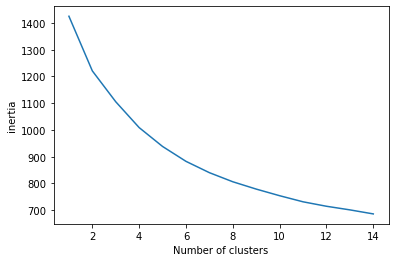

In [59]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [60]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[ 0.09350001,  0.00844384, -0.24265937,  0.26162191, -0.29210003,
        -0.16768075, -0.26902894,  0.02976602,  0.02115167,  0.02734995,
        -0.45255834, -0.22330223, -0.27574796, -0.17072701, -0.0214744 ,
         0.05628921],
       [-0.24083822, -0.01755504, -0.09064981,  0.05896779, -0.02643716,
        -0.08080512, -0.20275198, -0.15665109,  0.13187931, -0.13870156,
        -0.37810643, -0.24549518, -0.04457171, -0.24340114, -0.15640506,
         0.02425768],
       [-0.30268954,  0.28896399,  0.07170709, -0.01856131, -0.07802357,
        -0.08233846,  0.06819413, -0.12661117,  0.24034612,  0.05528159,
        -0.11260842,  0.02873664,  0.09803883,  0.14890026, -0.20117302,
         0.32669943],
       [ 0.17584864, -0.09714725,  0.07907308,  0.26315946, -0.1596338 ,
        -0.03862831, -0.29474053, -0.1085995 ,  0.07674199, -0.2430102 ,
        -0.38283696, -0.16149778,  0.10971199, -0.14055267,  0.14314564,
         0.10741945]])

In [63]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     8.687
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           8.82e-19
Time:                        19:13:12   Log-Likelihood:                -658.91
No. Observations:                 509   AIC:                             1352.
Df Residuals:                     492   BIC:                             1424.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5795      0.309     -1.875      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     15.86
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.16e-36
Time:                        19:13:54   Log-Likelihood:                -765.27
No. Observations:                 616   AIC:                             1565.
Df Residuals:                     599   BIC:                             1640.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0053      0.275      0.019      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [66]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     10.30
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.34e-20
Time:                        19:14:16   Log-Likelihood:                -333.34
No. Observations:                 283   AIC:                             700.7
Df Residuals:                     266   BIC:                             762.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7645      0.329     -2.325      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [67]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     5.395
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.73e-10
Time:                        19:14:36   Log-Likelihood:                -591.96
No. Observations:                 446   AIC:                             1218.
Df Residuals:                     429   BIC:                             1288.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0604      0.357     -0.169      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.25803844757073524

### Typicality

In [69]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [70]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,0.257196,-0.149601,0.097700,0.486571,-0.233932,-0.245791,-0.208891,-0.125042,0.207229,...,-0.429370,-0.037573,0.198956,-0.364910,0.262268,0.042607,0.779739,1,animal,0.810913
1,1,0.096372,-0.318087,0.098610,0.157793,-0.483288,0.096272,-0.014961,0.145142,0.152316,...,-0.322260,-0.518186,-0.236083,-0.494755,-0.079463,-0.186821,0.798485,13,home decor,0.247628
2,2,0.251363,-0.428372,-0.159658,0.183401,-0.629407,-0.192000,-0.175446,-0.112185,0.342690,...,-0.097542,-0.423873,-0.371135,-0.102663,-0.117751,0.017678,0.752845,18,musical instrument,0.624589
4,4,0.087201,0.012009,-0.120919,0.175571,-0.309702,0.164404,-0.634352,0.060360,0.019642,...,-0.054509,-0.350359,-0.142951,0.081127,0.455223,0.343431,0.794466,9,electronic device,0.522380
5,5,-0.069450,-0.003989,-0.214316,0.218524,-0.069509,0.065671,-0.320716,-0.083294,-0.057517,...,-0.080062,-0.174070,-0.007727,0.220850,-0.004462,0.462100,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,-0.089642,-0.243565,-0.091813,-0.098626,0.321606,-0.589159,0.543529,-0.012458,-0.332253,...,-0.358885,-0.100520,-0.163182,-0.109911,-0.185898,0.061870,0.803129,24,toy,0.246697
1848,1848,-0.260872,0.188415,-0.087191,-0.014198,0.033958,-0.101392,-0.234838,-0.182751,0.306640,...,-0.644833,-0.185797,-0.121185,-0.335999,-0.227808,0.185564,0.765881,10,food,0.786900
1850,1850,-0.318909,0.095347,-0.165039,0.002044,0.041825,-0.126988,-0.141498,-0.154243,0.257153,...,-0.586038,-0.259464,-0.091292,-0.388438,-0.104259,0.016681,0.843158,10,food,0.770485
1851,1851,0.306011,-0.125838,0.272022,0.457860,-0.221812,-0.235201,-0.226816,-0.101833,0.188664,...,-0.233460,-0.081794,0.178557,-0.230379,0.373962,-0.074590,0.800163,1,animal,0.764335


In [71]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     78.98
Date:                Sun, 21 Aug 2022   Prob (F-statistic):          7.85e-179
Time:                        19:16:35   Log-Likelihood:                -1430.9
No. Observations:                1324   AIC:                             2896.
Df Residuals:                    1307   BIC:                             2984.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1344      0.123     -1.089      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [72]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     31.80
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.09e-08
Time:                        19:17:03   Log-Likelihood:                -1862.9
No. Observations:                1324   AIC:                             3730.
Df Residuals:                    1322   BIC:                             3740.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.1490      0.204      5.639      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [77]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     33.08
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           3.52e-89
Time:                        19:22:33   Log-Likelihood:                -1641.6
No. Observations:                1324   AIC:                             3319.
Df Residuals:                    1306   BIC:                             3413.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5027      0.145     -3.470      0.0

In [78]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           7.98e-13
Time:                        19:23:48   Log-Likelihood:                -1850.8
No. Observations:                1324   AIC:                             3708.
Df Residuals:                    1321   BIC:                             3723.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0333      0.145      7.111      0.0

##### Cluster level typicality

In [79]:
concept_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
concept_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.257196,-0.149601,0.097700,0.486571,-0.233932,-0.245791,-0.208891,-0.125042,0.207229,...,-0.037573,0.198956,-0.364910,0.262268,0.042607,0.779739,1,animal,3,0.810913
1,1,0.096372,-0.318087,0.098610,0.157793,-0.483288,0.096272,-0.014961,0.145142,0.152316,...,-0.518186,-0.236083,-0.494755,-0.079463,-0.186821,0.798485,13,home decor,0,0.247628
2,2,0.251363,-0.428372,-0.159658,0.183401,-0.629407,-0.192000,-0.175446,-0.112185,0.342690,...,-0.423873,-0.371135,-0.102663,-0.117751,0.017678,0.752845,18,musical instrument,0,0.624589
3,4,0.087201,0.012009,-0.120919,0.175571,-0.309702,0.164404,-0.634352,0.060360,0.019642,...,-0.350359,-0.142951,0.081127,0.455223,0.343431,0.794466,9,electronic device,3,0.522380
4,5,-0.069450,-0.003989,-0.214316,0.218524,-0.069509,0.065671,-0.320716,-0.083294,-0.057517,...,-0.174070,-0.007727,0.220850,-0.004462,0.462100,0.806000,12,furniture,3,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-0.089642,-0.243565,-0.091813,-0.098626,0.321606,-0.589159,0.543529,-0.012458,-0.332253,...,-0.100520,-0.163182,-0.109911,-0.185898,0.061870,0.803129,24,toy,1,0.246697
1320,1848,-0.260872,0.188415,-0.087191,-0.014198,0.033958,-0.101392,-0.234838,-0.182751,0.306640,...,-0.185797,-0.121185,-0.335999,-0.227808,0.185564,0.765881,10,food,1,0.786900
1321,1850,-0.318909,0.095347,-0.165039,0.002044,0.041825,-0.126988,-0.141498,-0.154243,0.257153,...,-0.259464,-0.091292,-0.388438,-0.104259,0.016681,0.843158,10,food,1,0.770485
1322,1851,0.306011,-0.125838,0.272022,0.457860,-0.221812,-0.235201,-0.226816,-0.101833,0.188664,...,-0.081794,0.178557,-0.230379,0.373962,-0.074590,0.800163,1,animal,3,0.764335


In [80]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.548
Date:                Sun, 21 Aug 2022   Prob (F-statistic):             0.0394
Time:                        21:58:42   Log-Likelihood:                -443.29
No. Observations:                 316   AIC:                             896.6
Df Residuals:                     311   BIC:                             915.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1288      0.381      0.338      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     14.61
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           2.58e-32
Time:                        22:00:16   Log-Likelihood:                -594.12
No. Observations:                 488   AIC:                             1222.
Df Residuals:                     471   BIC:                             1293.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2845      0.335      0.849      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     7.173
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.12e-12
Time:                        22:00:29   Log-Likelihood:                -228.18
No. Observations:                 195   AIC:                             490.4
Df Residuals:                     178   BIC:                             546.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3474      0.431     -0.806      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     7.340
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.68e-14
Time:                        22:00:40   Log-Likelihood:                -408.67
No. Observations:                 325   AIC:                             851.3
Df Residuals:                     308   BIC:                             915.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6865      0.442     -1.554      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained slightly fewer variance in memorability compared to coordinates only. 

In [84]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.2553104586748748